# Importar el Dataset

In [1]:
"""
  Importar desde Drive el Dataset
"""
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Librerias Requeridas

In [2]:
"""
  Importar librerias requeridas para la manipulación y declaración de redes neuronales.
  Ademas se declara el control de imagenes.
  Incluso el control para evitar el sobreentrenamiento
"""
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import math
import logging

In [3]:
"""
  Declarar variables con información de las imagenes y para las funcionalidades del modelo
"""
IMG_SHAPE  = 256
batch_size = 32
random_seed = 9

In [4]:
"""
  Declaración del directorio conectando con drive.
  Obtención de las clases y la cantidad de clases detectadas
"""
fpath = r"/content/drive/MyDrive/Mineria/DatosFinales/dataset_normal_bg"
categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['Healthy', 'Esca', 'Leaf_blight', 'Blackrot'] 

No. of categories =  4


In [5]:
"""
  Declaración de la función que permite cargar las imagenes y sus etiquetas para ser impelmentadas como dataset
"""
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')
            
            img_lst.append(np.array(img_array))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  4062 
No. of labels loaded =  4062
<class 'list'> <class 'list'>


In [6]:
"""
  Realizar el transformado de las imagenes en array.
  Se muestra el numero de imagenes, el tamaño y el segmento de RGB
"""
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (4062, 256, 256, 3) 
Labels shape =  (4062,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


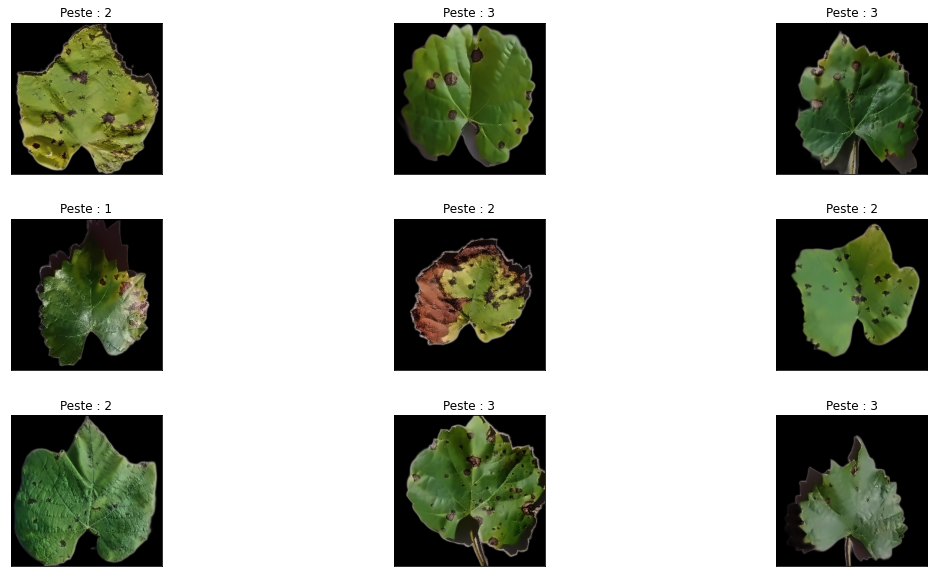

In [8]:
"""
  Recorrer el Dataset para obtener las imagenes correspondientes a su label perteneciente
"""
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Peste : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

In [9]:
"""
  Genera un array con las imagenes en base al tamaño de las mismas como dato inicial y dato final
"""
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 4059 4060 4061]

'n' values after shuffling =  [1980  529 1533 ... 2686  348  382]


In [10]:
"""
  Se declara dos variables las cuales permiten ingresar las imagenes con los valores creados previamente
"""
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (4062, 256, 256, 3) 
Labels shape after shuffling =  (4062,)


In [11]:
"""
  Se realiza la normalización de los datos transformando el tamaño de las imagenes
  donde se considera en base al tamaño maximo de rgb 
"""
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (4062, 256, 256, 3)


In [12]:
"""
  Se implementa la función train_split para dividr la data en 80% train y 20% test considerando que dentro se dividira en los datos para validación
"""

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (3191, 256, 256, 3)
y_train shape =  (3191,)

x_test shape =  (813, 256, 256, 3)
y_test shape =  (813,)

x_val shape =  (58, 256, 256, 3)
y_val shape =  (58,)


In [13]:
"""
  Se le especifica a las variables de las etiquetas de train, test y validation
  la cantidad de clases que disponen.
"""
y_train = to_categorical(y_train, 4)
y_test = to_categorical(y_test, 4)
y_val = to_categorical(y_val, 4)

In [16]:
"""
  Declaración del modelo donde este considera 7 convulucionales para su entrenamiento
"""
model = tf.keras.Sequential(
    [

    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu',input_shape=x_train[0].shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax'),
]
)

In [17]:
"""
  Se compila el modelo considerando las metricas para su recuperación
"""
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [18]:
"""
  Se corresponde generar el resumen obtenido de la declración del modelo
"""
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [19]:
"""
  Declaración de los saltos que va realizar el modelo considerando el tamaño de la variable de train
  A su vez se toma el valor validación de los datos
  De igual forma se declara la función que permite detener el modelo cuando este
  se encuentre realizando un sobrentrenamiento
"""
steps_per_epoch = (x_train.shape[0]//batch_size)
validation_steps = (x_val.shape[0] // batch_size)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [20]:
"""
  Se corresponde especificar el tiempo que demora el modelo en compilar su entrenamiento.
  Ademas se realizar el entrenamiento declarando una variable history para recuperar la información de las metricas
"""
start_time = time.time()

history = model.fit(x_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 5,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = batch_size,
    callbacks=[es],
    verbose=1)

logging.basicConfig(filename="CNN-withoutTL_log.txt", level=logging.INFO)
logging.info("Training Execution Time:" + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

Epoch 1/5
99/99 [==============================] - 359s 4s/step - loss: 0.9267 - acc: 0.5840 - val_loss: 0.6564 - val_acc: 0.8125
Epoch 2/5
99/99 [==============================] - 341s 3s/step - loss: 0.3931 - acc: 0.8496 - val_loss: 0.4266 - val_acc: 0.8438
Epoch 3/5
99/99 [==============================] - 345s 3s/step - loss: 0.2531 - acc: 0.9009 - val_loss: 0.3401 - val_acc: 0.8438
Epoch 4/5
99/99 [==============================] - 342s 3s/step - loss: 0.2000 - acc: 0.9234 - val_loss: 0.5516 - val_acc: 0.7812
Epoch 5/5
99/99 [==============================] - 342s 3s/step - loss: 0.1407 - acc: 0.9490 - val_loss: 0.1101 - val_acc: 0.9688


In [21]:
"""
  Se realizar la evaluación del modelo tomando los valores de las variables de test.
  Ademas se considera especificar el valor que se pierde durante el test y el accuracy obtenido
"""

start_time = time.time()

loss, accuracy = model.evaluate(x_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

logging.info("Evaluation Execution Time: " + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
logging.info("test_loss:" + str(loss))
logging.info("test accuracy:" + str(accuracy))

26/26 [==============================] - 26s 997ms/step - loss: 0.1656 - acc: 0.9360
test_loss: 16.56
test_accuracy: 93.60


In [22]:
"""
  Se considera implementar la predicción del modelo con los datos de test.
  De igual forma se implementa la declaración de las metricas tomando en consideración 
  que estos deben ser transformados a valores porcentuales para su comprensión
"""
model_probs = model.predict(x_test,batch_size=batch_size,verbose=0)
model_classes = np.argmax(model_probs,axis=1)
model_probs = model_probs[:, 0]
y_test_reduced = np.argmax(y_test,axis=1)
accuracy = accuracy_score(y_test_reduced, model_classes)*100
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)

Accuracy: 93.60
F1 score: 93.58
Precision: 93.61
Recall: 93.60


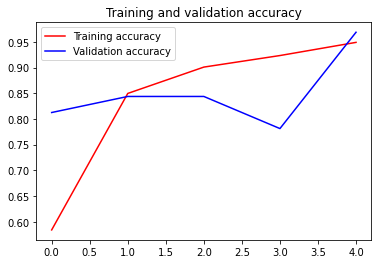

In [23]:
"""
  Recuperar la información ve la variable history para generar la creación de la grafica.
  Mediante la cual se especifica los valores al entrenar el modelo
"""
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - CNN-without TL.png")
plt.show()

# Matriz de Confusión

In [24]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

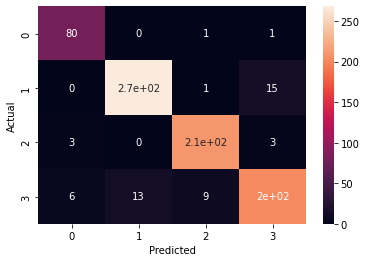

In [25]:
"""
  Generar la matriz de confusión en base a los valores entrantes como los salientes
  al momento de pasar por el modelo.
"""
confusion_matrix = pd.crosstab(y_test_reduced, model_classes, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()